# Image parsing

For each image, parse out each bounding box into a new image, use different naming conventions/folders for different coloured box

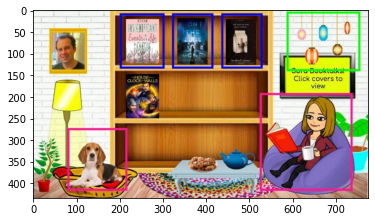

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns
import random as rng
import pandas as pd
import numpy as np
import cv2

path ='../data/input/user9_4519.jpg'

bitmoji = cv2.imread(path, 1)
bitmoji =  cv2.cvtColor(bitmoji, cv2.COLOR_BGR2RGB)
plt.imshow(bitmoji)
hsv_bitmoji = cv2.cvtColor(bitmoji, cv2.COLOR_RGB2HSV)

## Define Blue range



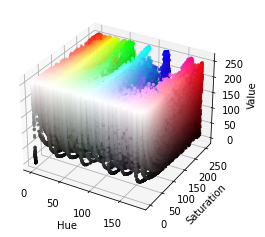

In [62]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

pixel_colors = bitmoji.reshape((np.shape(bitmoji)[0]*np.shape(bitmoji)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
h, s, v = cv2.split(hsv_bitmoji)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

# Find blue

(434, 775, 3) (434, 775, 3) (434, 775, 3)


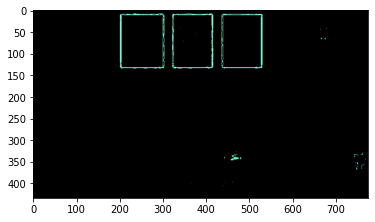

In [128]:
low_blue = np.array([90, 240,190])
high_blue = np.array([130, 260,250])
mask = cv2.inRange(hsv_bitmoji, low_blue, high_blue)
res = cv2.bitwise_and(hsv_bitmoji, hsv_bitmoji, mask = mask).astype(np.uint8)
print(res.shape,hsv_bitmoji.shape,bitmoji.shape)
plt.imshow(res) # result below

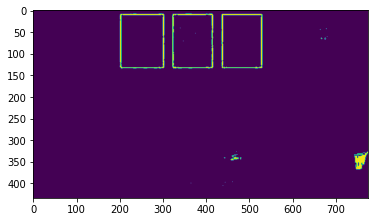

In [127]:
resgray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
plt.imshow(resgray)

### Adding a gaussian blur to the image and then performing edge detection helps eliminate noise

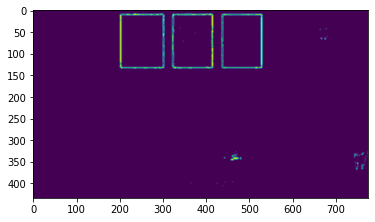

In [112]:
blurred = cv2.blur(resgray, (3,3))
plt.imshow(blurred)

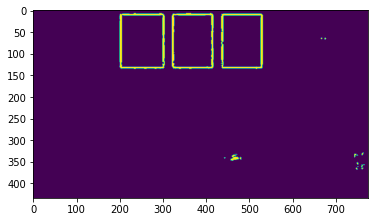

In [113]:
#Apply thresholding to the image
ret, thresh = cv2.threshold(blurred, 1, 255, cv2.THRESH_OTSU)
plt.imshow(thresh)

### Draw red boxes over top of the green boxes to confirm that we're picking up the correct items

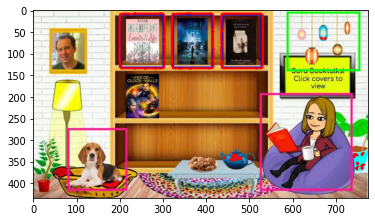

In [114]:
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cpy = bitmoji.copy()
cv2.drawContours(cpy, contours, -1, (255,0,0), 3)
plt.imshow(cpy)

### Our bounding boxes ought to be quite large and thus small ones can be assuemd to be noise

In [115]:
bounding_boxes = [cv2.boundingRect(c) for c in contours]
print(len(bounding_boxes))
bounding_boxes = [[x,y,w,h] for [x,y,w,h] in bounding_boxes if h*w*1000 and w > 40 and h > 40]
print(len(bounding_boxes))

16
3


<AxesSubplot:>

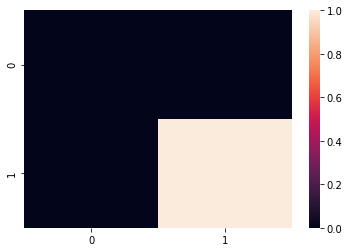

In [59]:
import torch
import torchvision.ops.boxes as bops

# The bbox is prepared in the format of [x1, y1, x2, y2].
box1 = torch.tensor([[511, 41, 577, 76]], dtype=torch.float)
box2 = torch.tensor([[544, 59, 610, 94]], dtype=torch.float)
iou = bops.box_iou(box1, box2)


ious = np.array([])
for x1,y1,w1,h1 in bounding_boxes:
    for x2,y2,w2,h2 in bounding_boxes:
        box1 = torch.tensor([[y1,y1+h1,x1,x1+w1]], dtype=torch.float)
        box2 = torch.tensor([[y2,y2+h2,x2,x2+w2]], dtype=torch.float)
        ious = np.append(ious,float(bops.box_iou(box1, box2)[0,0]))

ious = np.reshape(ious,(len(bounding_boxes),len(bounding_boxes)))
sns.heatmap(ious)

Area: 12416
8 136 435 532
Area: 12513
7 136 321 418
Area: 13545
7 136 200 305


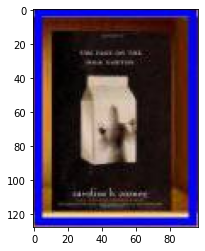

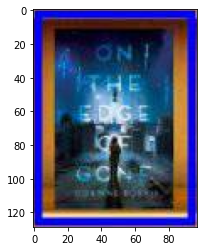

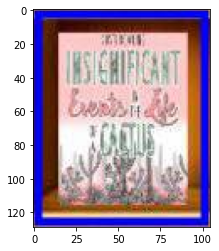

In [116]:
ROI_number = 0

for bb in bounding_boxes:
    x,y,w,h = bb
    area = h*w
    if area > 1000 and w > 40 and h > 40:
        print(f"Area: {area}")
        print(y,y+h, x,x+w)
        ROI = bitmoji[y:y+h, x:x+w]
        plt.figure()
        plt.imshow(ROI)

In [102]:
np.mean(hsv_bitmoji[3:5,756:758][0,:,:],axis=0)

array([ 56.5,  95.5, 233.5])